In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-11-03 19:49:26--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.4’

insurance.csv.4     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2022-11-03 19:49:26 (3.71 MB/s) - ‘insurance.csv.4’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


**Explore**

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset has no missing values and datatypes are correct for all features

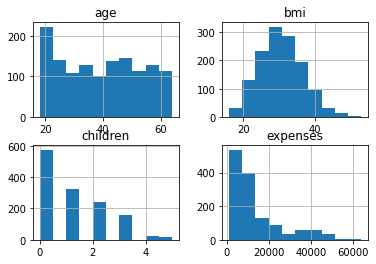

In [4]:
dataset.hist();

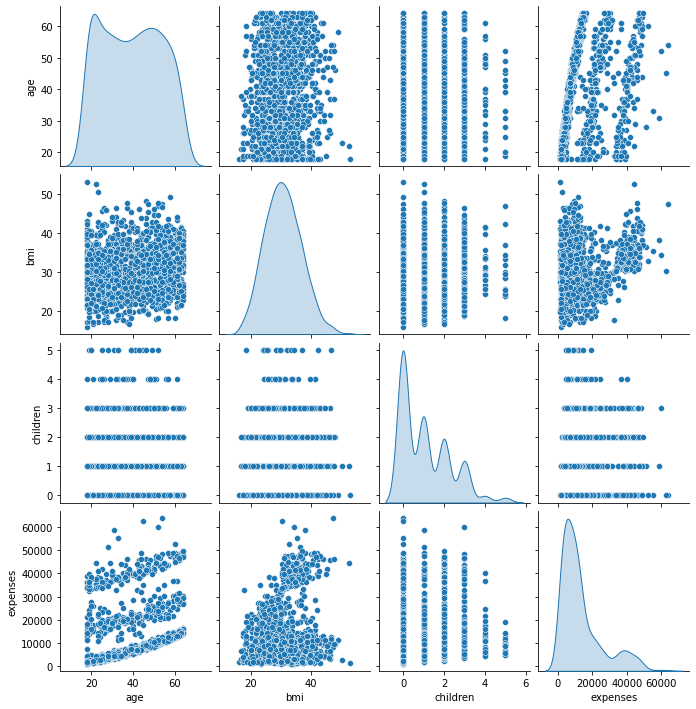

In [5]:
sns.pairplot(dataset, diag_kind='kde');

In [6]:
dataset.corr()

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


There is no issue of multi-collinearity.

Convert categorical data into numeric representation.

In [7]:
dataset = pd.get_dummies(dataset, columns=['sex','smoker','region'])
dataset.tail()


,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1333,50,31.0,3,10600.55,0,1,1,0,0,1,0,0
1334,18,31.9,0,2205.98,1,0,1,0,1,0,0,0
1335,18,36.9,0,1629.83,1,0,1,0,0,0,1,0
1336,21,25.8,0,2007.95,1,0,1,0,0,0,0,1
1337,61,29.1,0,29141.36,1,0,0,1,0,1,0,0


**Split**

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

In [9]:
train_dataset.shape

(1070, 12)

In [10]:
test_dataset.shape

(268, 12)

Split `features` from `labels`.

In [11]:
train_dataset = train_dataset.copy()
test_dataset = test_dataset.copy()

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')



In [12]:
print("Train dataset shape: ",train_dataset.shape)
print("Test dataset shape: ",test_dataset.shape)

Train dataset shape:  (1070, 11)
Test dataset shape:  (268, 11)


In [13]:
print("Train labels shape: ",train_labels.shape)
print("Test labels shape: ",test_labels.shape)

Train labels shape:  (1070,)
Test labels shape:  (268,)


**Build Model**

Normalization Layer

In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

In [15]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1)
])


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [17]:
#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=['mae', 'mse'])


In [18]:
# Fit the model to the data
%%time
history = model.fit(
    train_dataset,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


CPU times: user 9.72 s, sys: 542 ms, total: 10.3 s
Wall time: 11.3 s


**Evaluate**

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Expenses]')
  plt.legend()
  plt.grid(True)


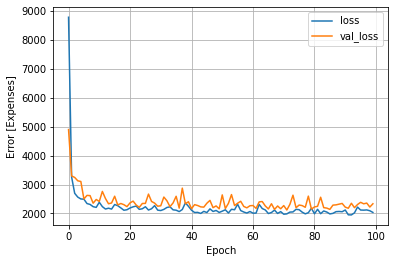

In [20]:
plot_loss(history)

In [21]:
model.evaluate(
    test_dataset, test_labels,
    verbose=0)


[2378.390625, 2378.390625, 29348826.0]

9/9 - 0s - loss: 2378.3906 - mae: 2378.3906 - mse: 29348826.0000 - 57ms/epoch - 6ms/step
Testing set Mean Abs Error: 2378.39 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 3ms/step


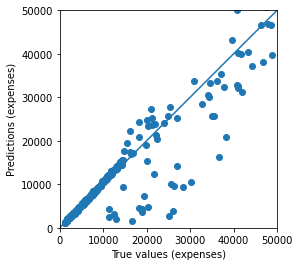

In [22]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
